In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import substring, length, col, expr
from pyspark.sql.functions import regexp_replace, concat
from pyspark.ml import PipelineModel
from datetime import timezone,datetime 
from itertools import chain

#### 1. Setting the config

In [2]:
#Defnined conifg according to assingment spec
spark_conf = SparkConf().setMaster("local[2]").setAppName("Assignment_Spark_Streaming").set("spark.sql.session.timeZone", "UTC")

In [3]:
#Create spark session
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate() 

#### 2. Ingesting data from task 1.1 and task 1.2

In [4]:
#start kafka stream with this topic name
topic = "Assignment2B-process"
df_process = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

In [5]:
topic = "Assignment2B-memory"
df_memory = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

In [6]:
df_memory.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



#### 3. Transforming data according to schema and defined assignment specification.

In [7]:
#Schema from previous assignments
#process schema
procSchema = ArrayType(StructType([StructField("sequence",IntegerType(),True),
                                   StructField("machine",IntegerType(),True),
                                   StructField("ts",TimestampType(),True),
         StructField("PID",IntegerType(),True),
         StructField("TRUN",IntegerType(),True),
         StructField("TSLPI",IntegerType(),True),
         StructField("TSLPU",IntegerType(),True),
         StructField("POLI",StringType(),True),
         StructField("NICE",IntegerType(),True),
         StructField("PRI",IntegerType(),True),
         StructField("RTPR",IntegerType(),True),
         StructField("CPUNR",IntegerType(),True),
         StructField("Status",StringType(),True),
         StructField("EXC",IntegerType(),True),
         StructField("State",StringType(),True),
         StructField("CPU",DoubleType(),True),
         StructField("CMD",StringType(),True)]))
#Mem Schema
memSchema = ArrayType(StructType([StructField("sequence",IntegerType(),True),
                                   StructField("machine",IntegerType(),True),
                                  StructField("ts",TimestampType(),True),
                       StructField("PID",DoubleType(),True),
                       StructField("MINFLT",StringType(),True),
                       StructField("MAJFLT",StringType(),True),
                       StructField("VSTEXT",StringType(),True),
                       StructField("VSIZE",DoubleType(),True),
                       StructField("RSIZE",StringType(),True),
                       StructField("VGROW",StringType(),True),
                       StructField("RGROW",StringType(),True),
                       StructField("MEM",DoubleType(),True),
                       StructField("CMD",StringType(),True)]))

In [8]:
df_process.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [9]:
df_memory = df_memory.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")
df_process = df_process.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [10]:
#Parse the values received
df_memory = df_memory.select(F.from_json(F.col("value").cast("string"),memSchema).alias('parsed_value'))
df_memory = df_memory.select(F.explode(F.col("parsed_value")).alias('unnested_value'))
#Parse the values received
df_process = df_process.select(F.from_json(F.col("value").cast("string"),procSchema).alias('parsed_value'))
df_process = df_process.select(F.explode(F.col("parsed_value")).alias('unnested_value'))

In [11]:
#Check schema for columns
df_process.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- ts: timestamp (nullable = true)
 |    |-- PID: integer (nullable = true)
 |    |-- TRUN: integer (nullable = true)
 |    |-- TSLPI: integer (nullable = true)
 |    |-- TSLPU: integer (nullable = true)
 |    |-- POLI: string (nullable = true)
 |    |-- NICE: integer (nullable = true)
 |    |-- PRI: integer (nullable = true)
 |    |-- RTPR: integer (nullable = true)
 |    |-- CPUNR: integer (nullable = true)
 |    |-- Status: string (nullable = true)
 |    |-- EXC: integer (nullable = true)
 |    |-- State: string (nullable = true)
 |    |-- CPU: double (nullable = true)
 |    |-- CMD: string (nullable = true)



In [12]:
#convert columns into more manageble format
df_process = df_process.select(
    F.col("unnested_value.sequence").alias("sequence"),
    F.col("unnested_value.machine").alias("machine"),
    F.col("unnested_value.ts").alias("ts"),
    F.col("unnested_value.PID").alias("PID"),
    F.col("unnested_value.TRUN").alias("TRUN"),
    F.col("unnested_value.TSLPI").alias("TSLPI"),
    F.col("unnested_value.TSLPU").alias("TSLPU"),
    F.col("unnested_value.POLI").alias("POLI"),
    F.col("unnested_value.NICE").alias("NICE"),
    F.col("unnested_value.PRI").alias("PRI"),
    F.col("unnested_value.RTPR").alias("RTPR"),
    F.col("unnested_value.CPUNR").alias("CPUNR"),
    F.col("unnested_value.Status").alias("Status"),
    F.col("unnested_value.EXC").alias("EXC"),
    F.col("unnested_value.State").alias("State"),
    F.col("unnested_value.CPU").alias("CPU"),
    F.col("unnested_value.CMD").alias("CMD"))

In [13]:
#Check schema for columns
df_process.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)



In [14]:
#Check schema for columns
df_memory.printSchema()

root
 |-- unnested_value: struct (nullable = true)
 |    |-- sequence: integer (nullable = true)
 |    |-- machine: integer (nullable = true)
 |    |-- ts: timestamp (nullable = true)
 |    |-- PID: double (nullable = true)
 |    |-- MINFLT: string (nullable = true)
 |    |-- MAJFLT: string (nullable = true)
 |    |-- VSTEXT: string (nullable = true)
 |    |-- VSIZE: double (nullable = true)
 |    |-- RSIZE: string (nullable = true)
 |    |-- VGROW: string (nullable = true)
 |    |-- RGROW: string (nullable = true)
 |    |-- MEM: double (nullable = true)
 |    |-- CMD: string (nullable = true)



In [15]:
#convert columns into more manageble format
df_memory = df_memory.select(
    F.col("unnested_value.sequence").alias("sequence"),
    F.col("unnested_value.machine").alias("machine"),
    F.col("unnested_value.ts").alias("ts"),
    F.col("unnested_value.PID").alias("PID"),
    F.col("unnested_value.MINFLT").alias("MINFLT"),
    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
    F.col("unnested_value.VSIZE").alias("VSIZE"),
    F.col("unnested_value.RSIZE").alias("RSIZE"),
    F.col("unnested_value.VGROW").alias("VGROW"),
    F.col("unnested_value.RGROW").alias("RGROW"),
    F.col("unnested_value.MEM").alias("MEM"),
    F.col("unnested_value.CMD").alias("CMD"))

In [16]:
df_memory.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- PID: double (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)



In [17]:
#Wrangling the data into proper format for the following columns
#By chekcing for condition we can change to value to its corresponsing corerct form.
df_memory = df_memory.withColumn('MINFLT',\
when(col("MINFLT").contains('K'),expr('substring(MINFLT,1,length(MINFLT)-1)').cast('double')*1000)
.otherwise(col("MINFLT").cast('double')))

df_memory = df_memory.withColumn('MAJFLT',\
when(col("MAJFLT").contains('M'),expr('substring(MAJFLT,1,length(MAJFLT)-1)').cast('double')*1000000)
.otherwise(col("MAJFLT").cast('double')))

df_memory = df_memory.withColumn('VSTEXT',\
when(col("VSTEXT").contains('K'),expr('substring(VSTEXT,1,length(VSTEXT)-1)').cast('double')*1000)
.otherwise(col("VSTEXT").cast('double')))

df_memory = df_memory.withColumn('RSIZE',\
when(col("RSIZE").contains('K'),expr('substring(RSIZE,1,length(RSIZE)-1)').cast('double')*1000)
.when(col("RSIZE").contains('M'),expr('substring(RSIZE,1,length(RSIZE)-1)').cast('double')*1000000)        
.otherwise(col("RSIZE").cast('double')))

df_memory = df_memory.withColumn('VGROW',\
when(col("VGROW").contains(' '),regexp_replace(col("VGROW")," ","").cast('double'))
.when(col("VGROW").contains('K'),expr('substring(VGROW,1,length(VGROW)-1)').cast('double')*1000)
.otherwise(col("VGROW").cast('double')))

df_memory = df_memory.withColumn('RGROW',\
when(col("RGROW").contains('K'),expr('substring(RGROW,1,length(RGROW)-1)').cast('double')*1000)
.otherwise(col("RGROW").cast('double')))

#Process
df_process = df_process.withColumn("NICE", F.when(F.col("PRI")==0, 0).otherwise(F.col("PRI")-120))

#### 4. Creating columns 'CMD_PID' and 'event_time' for process and memory respectively.

In [18]:
#Concatenate column 
df_process = df_process.withColumn("CMD_PID", concat(F.col('CMD'),F.col("PID"))) 
#Converted in Schema so creating a columns for working
df_memory = df_memory.withColumn("event_time",F.col('ts'))

#### 5. Persist trasformed data into parquet for both process and memory.

In [19]:
# Write into parquet files the unsuccessful requests partitioned by status code
query_file_sink_process = df_process.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process.parquet")\
        .queryName('process_parquet')\
        .option("checkpointLocation", "process.parquet/checkpoint")\
        .start()

In [20]:
# Write into parquet files the unsuccessful requests partitioned by status code
query_file_sink_memory = df_memory.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory.parquet")\
        .queryName('memory_parquet')\
        .option("checkpointLocation", "memory.parquet/checkpoint")\
        .start()

In [21]:
#Uncomment to stop queries
# query_file_sink_process.stop()
# query_file_sink_memory.stop()

In [22]:
# Read the saved parquet data
query_file_sink_df = spark.read.parquet("memory.parquet/")
query_file_sink_df.printSchema()
query_file_sink_df.show()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- PID: double (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- CDM_PID: string (nullable = true)

+--------+-------+-------------------+------+------+------+------+-------+-------+-------+------+----+--------------+--------------------+
|sequence|machine|                 ts|   PID|MINFLT|MAJFLT|VSTEXT|  VSIZE|  RSIZE|  VGROW| RGROW| MEM|           CMD|             CDM_PID|
+--------+-------+-------------------+------+------+------+------+-------+-------+-------+------+----+--------------+--------------------+
|      67|      5|2020-10-31 20:15:34|1406.0|   0.0| 

#### 6. Load the given machine learning model into the pipeline and predict whether each process or memory streaming record is an attack respectivly or not.

In [23]:
#Load models
procPipeline = PipelineModel.load('process_pipeline_model')
memPipeline = PipelineModel.load('memory_pipeline_model')

#### 7A. 

In [24]:
#Predict using the model
transformed_mem = memPipeline.transform(df_memory)
transformed_proc = procPipeline.transform(df_process)

In [55]:
#Process
windowedCounts_proc = transformed_proc \
.withWatermark("ts", "120 seconds") \
    .where('prediction==1')\
    .groupBy(F.window(df_process.ts, "120 seconds"),F.col('machine'))\
    .agg(F.approx_count_distinct("CMD_PID").alias("total"))\
    .select("window","machine","total")
   
#For assignment
#Query for process eith query name
query_proc_sql = windowedCounts_proc \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("proc_sql_mem")\
    .trigger(processingTime='5 seconds') \
    .option("truncate","false")\
    .start()

In [56]:
#Memory
windowedCounts_mem = transformed_mem \
.withWatermark("ts", "120 seconds") \
    .where('prediction==1')\
    .groupBy(F.window(df_memory.ts, "120 seconds"),F.col('machine'))\
    .agg(F.count("machine").alias("total"))\
    .select("window","machine","total")

#For assignment
#Query for process eith query mem
query_mem_sql = windowedCounts_mem \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("mem_sql_mem")\
    .trigger(processingTime='5 seconds') \
    .option("truncate","false")\
    .start()

In [76]:
# #Uncomment to stop all queries.
# query_mem.stop()
# query_proc.stop()
# query_mem_sql.stop()
# query_proc_sql.stop()

#### 7B.

In [28]:
#Select rows from tranformed dataframe
temp_proc = transformed_proc\
            .selectExpr("CMD as procCMD","PID AS procPID","TRUN","TSLPI","TSLPU","POLI","NICE"\
                       ,"PRI","RTPR","CPUNR","Status","EXC","State","CPU","ts as tsProc","CMD_PID","prediction as predProc"\
                       ,"sequence As sequenceProc","machine AS machineProc")\
            .withWatermark("tsProc","20 seconds")
#Select rows from tranformed dataframe
temp_mem = transformed_mem\
            .selectExpr("CMD as memCMD","PID as memPID","sequence AS sequenceMem","machine as machineMem","MINFLT",\
                       "MAJFLT","VSTEXT","VSIZE","RSIZE","VGROW","RGROW","MEM","ts as tsMem","event_time as event_timeMem"\
                       ,'prediction as predMem')

In [29]:
#streams are joined and conditions are applied
df_joined_stream = temp_proc.join(temp_mem,expr("""
    procCMD = memCMD AND
    procPID = memPID AND
    predProc = 1 AND
    predMem = 1 AND
    tsProc <= tsMem + interval 30 seconds AND
    tsMem <= tsProc + interval 30 seconds
"""))


In [30]:
df_joined_stream = df_joined_stream.withColumn("processing_time",F.lit(int(datetime.now().replace(tzinfo=timezone.utc).timestamp())))

In [31]:
#For assignment
# Write into parquet files the unsuccessful requests partitioned by status code
joined_attack_stream = df_joined_stream.select("procCMD","procPID","TRUN","TSLPI","TSLPU","POLI","NICE"\
                                       ,"PRI","RTPR","CPUNR","Status","EXC","State","CPU","tsProc","predProc"\
                                       ,"memCMD","memPID","MAJFLT","VSTEXT","VSIZE","RSIZE","VGROW","RGROW","MEM","tsMem"\
                                       ,"event_timeMem","predMem","sequenceMem","machineMem","sequenceProc","machineProc","processing_time")\
        .writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process_memory_attack.parquet")\
        .queryName('process_memory_attack_parquet')\
        .option("checkpointLocation", "process_memory_attack.parquet/checkpoint")\
        .start()

In [33]:
# Read the saved parquet data for displaying
joined_attack_parquet_sink = spark.read.parquet("process_memory_attack.parquet/")
joined_attack_parquet_sink.printSchema()
joined_attack_parquet_sink.show()

root
 |-- procCMD: string (nullable = true)
 |-- procPID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- tsProc: timestamp (nullable = true)
 |-- predProc: double (nullable = false)
 |-- memCMD: string (nullable = true)
 |-- memPID: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- tsMem: timestamp (nullable = true)
 |-- event_timeM

In [34]:
# joined_attack_stream.stop()

In [35]:
# joined_attack_stream_debug.stop()

#### 8. Plotting task 7A

In [36]:
#Taken from tutorials
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


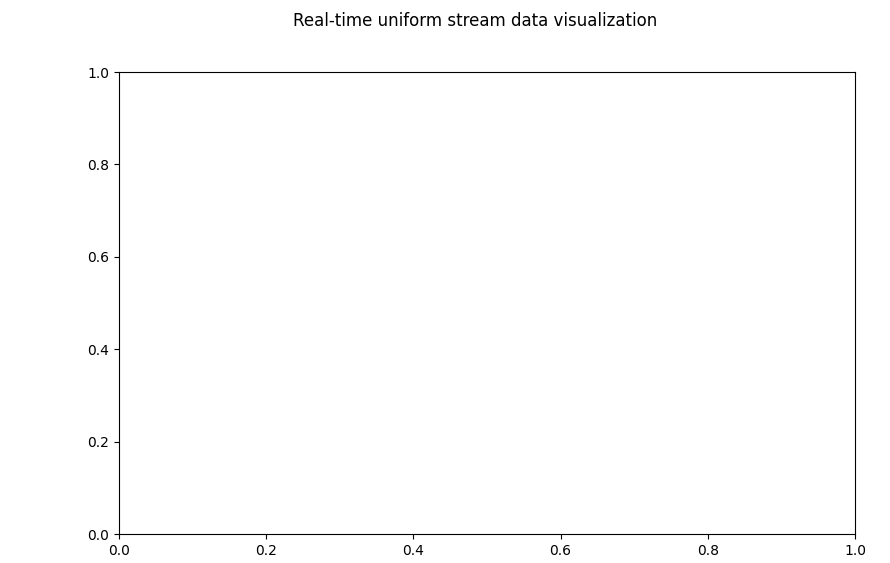

starting
in loop
3
in loop
2
in loop
3
in loop
2
in loop
3
in loop
2
in loop
5
in loop
4
in loop
2
in loop
2
in loop
3
in loop
5
in loop
2
in loop
3
in loop
3
in loop
4
in loop
4
in loop
5
in loop
5
in loop
4
in loop
2
in loop
5
in loop
4
in loop
4
in loop
5
in loop
3
in loop
4
in loop
5
{4: 833, 5: 1178, 6: 721, 7: 902, 8: 334}
[1604271960.0, 1604272080.0, 1604271480.0, 1604271720.0, 1604271720.0, 1604271960.0, 1604271840.0, 1604271960.0, 1604271600.0, 1604271480.0, 1604271600.0, 1604271720.0, 1604271360.0, 1604272080.0, 1604271840.0, 1604271360.0, 1604271840.0, 1604271960.0, 1604272080.0, 1604272080.0, 1604271840.0, 1604271600.0, 1604271480.0, 1604271600.0, 1604271360.0, 1604271360.0, 1604271720.0, 1604271480.0]


ValueError: x and y must have same first dimension, but have shapes (28,) and (0,)

In [75]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

fig, ax = init_plots()
y4, y5, y6, y7, y8 = [], [], [],[],[]
x=[]
#attack machine count
# count_machine_dict = {4:0,5:0,6:0,7:0,8:0}
while True:
    df_temp_proc = spark.sql("select * from proc_sql_mem").toPandas()
    df_temp_mem = spark.sql("select * from mem_sql_mem").toPandas()
    #calculate attacks in proc
    print('starting')
    y4, y5, y6, y7, y8 = [], [], [],[],[]
    x=[]
    for index, row in df_temp_proc.iterrows():
        print('in loop')
        if row['machine']==4:
            x.append(row['window'][0])
            y4.append(row['total'])
            print('1')
        elif row['machine']==5:
            x.append(row['window'][0])
            y5.append(row['total'])
            print('2')
        elif row['machine']==6:
            y6.append(row['total'])
            x.append(row['window'][0])
            print('3')
        elif row['machine']==7:
            y7.append(row['total'])
            x.append(row['window'][0])
            print('4')
        elif row['machine']==8:
            print('5')
            y8.append(row['total'])
            x.append(row['window'][0])
#     #Calculate attakcs in mem    
#     for index, row in df_temp_proc.iterrows():
#         print('in loop')
#         x.append(row['window'][0])
#         if row['machine']==4:
#             y4.append(row['total'])
#             x.append(row['window'][0])
#             print('1')
#         elif row['machine']==5:
#             y5.append(row['total'])
#             x.append(row['window'][0])
#             print('2')
#         elif row['machine']==6:
#             y6.append(row['total'])
#             x.append(row['window'][0])
#             print('3')
#         elif row['machine']==7:
#             y7.append(row['total'])
#             x.append(row['window'][0])
#             print('4')
#         elif row['machine']==8:
#             print('5')
#             x.append(row['window'][0])
#             y8.append(row['total'])
    
    print(count_machine_dict)
    x = [temp.timestamp() for temp in x]
#     y4.append(count_machine_dict[4])
#     y5.append(count_machine_dict[5])
#     y6.append(count_machine_dict[6])
#     y7.append(count_machine_dict[7])
#     y8.append(count_machine_dict[8])
    if len(x)>10:
        ax.clear()
        print(x)
        ax.plot(x,y4)
        y4.pop(0)
        ax.plot(x,y5)
        y5.pop(0)
        ax.plot(x,y6)
        y6.pop(0)
        ax.plot(x,y7)
        y7.pop(0)
        ax.plot(x,y8)
        y8.pop(0)
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')    
        fig.canvas.draw()
        x.pop(0) 
#     print(y)
#     print(x)
    print("#####################")
    time.sleep(20)
    

#### Reference

1. https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
2. https://stackoverflow.com/